In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import seaborn as sns
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models
import sys
import pickle
import dill as dill 
import warnings 
import itertools 
from tqdm import tqdm 
from collections import Counter 
from collections import OrderedDict
import time 
from pytz import timezone 
from datetime import datetime
import string
from pathlib import Path

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Utility functions
if "OrigFigSize" not in locals() and "OrigFigSize" not in globals():
    OrigFigSize   = plt.rcParams["figure.figsize"]

NonNans = lambda List: List[np.logical_not(np.isnan(List))]
LastNonNan = lambda List: NonNans(List)[-1] if np.sum(np.isnan(List)) < len(List) else np.array([]) if type(List) == np.ndarray else []

def ZeroANumber(Number, MaxLength, ForceMaxLength = False):
    res = str(Number).zfill(MaxLength)
    if ForceMaxLength: res = res[:MaxLength]
    return res

def SpaceAString(CurString, MaxLength, SpaceTheFront = True, ForceMaxLength = False, ForceRemoveFromFront = False):
    CurLen = len(CurString)
    Result = CurString
    
    if CurLen < MaxLength:
        if SpaceTheFront:
            Result = (" " * (MaxLength-CurLen)) + CurString
        else:
            Result = CurString + (" " * (MaxLength-CurLen))
    elif CurLen > MaxLength and ForceMaxLength:
        if ForceRemoveFromFront:
            Result = CurString[(CurLen - MaxLength):]
        else:
            Result = CurString[:-(CurLen - MaxLength)]
    return Result

def WriteText(TextParsableVar, FullFilePath):
    try:
        DirName = Path(FullFilePath).parent.absolute()
        os.makedirs(DirName, exist_ok = True)
        
        FileOptions = open(FullFilePath, "w")
        FileOptions.writelines(
            f"{TextParsableVar}"
        )
    except Exception as e:
        print(f"Exception:\n{e}")
    finally:
        try:
            FileOptions.close()
        except Exception:
            pass
SaveText = lambda TextParsableVar, FullFilePath: WriteText(TextParsableVar, FullFilePath)

def ReadText(FullFilePath):
    with open(FullFilePath, "r+", encoding = "utf8") as io:
        TextString = io.read()
    return TextString
LoadText = lambda FullFilePath: ReadText(FullFilePath)

def SaveVariable(Variable, FileName):
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        pickle.dump(Variable, io)

def SaveVariableDill(Variable, FileName):
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        dill.dump(Variable, io)
    
def LoadVariable(FileName):
    with open(FileName, "rb") as io:
        Res = pickle.load(io)
    return Res

def LoadVariableDill(FileName):
    with open(FileName, 'rb') as io:
        Res = dill.load(io)
    return Res

def RemLastLine(s):
    return s[:s.rfind('\n')]

In [ ]:
#CNN Conv 2D
class Net(nn.Module):
    def __init__(self, K_Length, activation, layer_type, num_units, usebias, dropout, conv_input_size, conv_output_size, conv_filter_size, conv_stride, conv_padding, batchnorm_momentum, conv_pool_size, conv_pool_stride, conv_pool_padding, conv_pool_dilation):
        super(Net, self).__init__()
        self.K_Length = K_Length
        self.layer_type = layer_type
        self.num_units = num_units
        self.activation = activation
        self.usebias = usebias
        self.dropout = dropout
        self.conv_input_size = conv_input_size
        self.conv_output_size = conv_output_size
        self.conv_filter_size = conv_filter_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.batchnorm_momentum = batchnorm_momentum
        self.conv_pool_size = conv_pool_size
        self.conv_pool_stride = conv_pool_stride
        self.conv_pool_padding = conv_pool_padding
        self.conv_pool_dilation = conv_pool_dilation
        
        self.layers = nn.ModuleList([
            nn.Conv2d(self.conv_input_size[-1], self.num_units[1], kernel_size = self.conv_filter_size, stride = self.conv_stride if self.layer_type[0] == "stridedconv" else 1, padding = self.conv_padding[0], bias = self.usebias[0]),
            nn.BatchNorm2d(self.num_units[1], eps = 1e-05, momentum = self.batchnorm_momentum[0], affine = True, track_running_stats = True),
            self.GetActivationLayer(0),
            nn.Dropout(p = self.dropout[0], inplace = False),
            
            nn.Conv2d(self.num_units[1], self.num_units[2], kernel_size = self.conv_filter_size, stride = self.conv_stride if self.layer_type[1] == "stridedconv" else 1, padding = self.conv_padding[1], bias = self.usebias[1]),
            nn.BatchNorm2d(self.num_units[2], eps = 1e-05, momentum = self.batchnorm_momentum[1], affine = True, track_running_stats = True),
            self.GetActivationLayer(1),
            nn.Dropout(p = self.dropout[1], inplace = False),
            
            nn.Conv2d(self.num_units[2], self.num_units[3], kernel_size = self.conv_filter_size, stride = 1, padding = self.conv_padding[2], bias = self.usebias[2]),
            nn.MaxPool2d(kernel_size = self.conv_pool_size, stride = self.conv_pool_stride, padding = self.conv_pool_padding, dilation = self.conv_pool_dilation, ceil_mode = False),
            nn.BatchNorm2d(self.num_units[3], eps = 1e-05, momentum = self.batchnorm_momentum[2], affine = True, track_running_stats = True),
            self.GetActivationLayer(2),
            nn.Dropout(p = self.dropout[2], inplace = False),
            
            nn.Linear(in_features = self.conv_output_size[3], out_features = self.num_units[4], bias = self.usebias[3]),
            self.GetActivationLayer(3),
            nn.Dropout(p = self.dropout[3], inplace = False),

            nn.Linear(in_features = self.conv_output_size[4], out_features = self.num_units[5], bias = self.usebias[4]),
            self.GetActivationLayer(4),
            nn.Dropout(p = self.dropout[4], inplace = False),

            nn.Linear(in_features = self.num_units[5], out_features = K_Length, bias = self.usebias[5])
        ])
    
    def forward(self, x):
        out = self.layers[0](x)
        out = self.layers[1](out)
        out = self.layers[2](out)
        out = self.layers[3](out)
        out = self.layers[4](out)
        out = self.layers[5](out)
        out = self.layers[6](out)
        out = self.layers[7](out)
        out = self.layers[8](out)
        out = self.layers[9](out)
        out = self.layers[10](out)
        out = self.layers[11](out)
        out = self.layers[12](out)
        out = out.reshape(out.shape[0], -1)
        out = self.layers[13](out)
        out = self.layers[14](out)
        out = self.layers[15](out)
        out = self.layers[16](out)
        out = self.layers[17](out)
        out = self.layers[18](out)
        out = self.layers[19](out)
        return out
    
    def GetActivationLayer(self, layer):
        Result = None
        if (self.activation[layer] == "relu"): 
            Result = nn.LeakyReLU(ReluAlpha) if ReluAlpha != 0 else nn.ReLU() 
        elif (self.activation[layer] == "relu6"):
            Result = nn.ReLU6()
        elif (self.activation[layer] == "elu"): 
            Result = nn.ELU(alpha = EluAlpha) 
        elif (self.activation[layer] == "tanh"):
            Result = nn.Tanh()
        elif (self.activation[layer] == "sigmoid"): 
            Result = nn.Sigmoid() 
        return Result

In [ ]:
def train_valid_test_split(X_Data, train_size, valid_size, Y_Data = None, random_state = None, shuffle = True, stratify = None):
    #Split the dataset into a Train, Validation and Test set
    
    if (type(train_size) == int and sum([train_size, valid_size]) >= len(X_Data)) or (type(train_size) != int and sum([train_size, valid_size]) >= 1):
        raise ValueError(f"The train_size [{train_size}] + the valid_size [{valid_size}] should sum up to less than 100% so that there's some percentage left for the test set")
    
    TrainIdx, ValidTestIdx = train_test_split(np.arange(len(X_Data)), train_size = train_size, shuffle = shuffle, stratify = stratify, random_state = random_state)
    TrainX     = X_Data[TrainIdx]
    ValidTestX = X_Data[ValidTestIdx]
    if Y_Data is not None:
        TrainY     = Y_Data[TrainIdx]
        ValidTestY = Y_Data[ValidTestIdx]
    
    if type(train_size) != int:
        test_size  = 1 - train_size - valid_size 
        valid_size = 1 - (test_size / (valid_size + test_size)) 
        test_size  = 1 - valid_size 
    
    if Y_Data is not None:
        ValidX, TestX, ValidY, TestY = train_test_split(ValidTestX, ValidTestY, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX, TrainY, ValidY, TestY
    else:
        ValidX, TestX = train_test_split(ValidTestX, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX

In [ ]:
def ClassAccMulti(Targets, Preds, K):
# Calculate the Class-Wise accuracy for a multi-class task
    return(np.mean([(Targets == k) == (Preds == k) for k in range(K)]))

In [ ]:
def AccCalculation(Y_Hat, Targets):    
# Calculate the Accuracy given the Actual values and Predictions for Binary and Multiclass Classification
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
        
    return np.mean(Y_Hat == Targets)

In [ ]:
def AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = True):
# Calculate the Area Under the ROC Curve given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's roc_auc_score()
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Prob, torch.Tensor):
        Y_Prob = Y_Prob.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric2 = roc_auc_score(Targets, Y_Prob, multi_class = "ovr", average = 'weighted') #Calculating Weighted AUC #Cares for performance both in Positives and Negatives (but may not fare well with heavy class imbalance)
    except Exception as exc:
        CurMetric2 = np.nan
        if Verbose:
            warnings.warn(f"\nAn error occurred in AUC calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            print("AUC Warning. set(Targets):", list(set(Targets.reshape(-1))), "set(Outputs): ", list(set(Y_Hat.reshape(-1))))
            
    return CurMetric2

In [ ]:
def F1ScoreCalculation(Targets, Y_Hat):
# Calculate the F1 score given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's f1_score()
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric3 = f1_score(Targets, Y_Hat, average = 'weighted') #Calculating Weighted F1 #Cares about balance between Precision and Recall (Sensitivity)
    except Exception as exc:
        CurMetric3 = np.nan
        warnings.warn(f"\nAn error occurred in F1 score calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            
    return CurMetric3

In [ ]:
def PrintIterationMetrics(it, epochs, t0, train_loss, test_loss, first_metric, first_metric_Name, second_metric, second_metric_Name, third_metric, third_metric_Name, MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len):
#Print information about the Current Epoch, Train/Test losses, return the Max length of each metric
    dt = datetime.now() - t0

    strTrainLoss = f"{train_loss:.4f}"
    strTestLoss = f"{test_loss:.4f}"
    strMetric1 = f'{first_metric:.3f}'
    strMetric2 = f'{second_metric:.3f}'
    strMetric3 = f'{third_metric:.3f}'
    if it == 0:
        MaxTrainLossLen = len(strTrainLoss)
        MaxTestLossLen = len(strTestLoss)
        MaxMetric1Len = len(strMetric1)
        MaxMetric2Len = len(strMetric2)
        MaxMetric3Len = len(strMetric3)
    print(f'Epoch {ZeroANumber(it+1, len(str(epochs)))}/{epochs}, Train Loss: {SpaceAString(strTrainLoss, MaxTrainLossLen)}, Test Loss: {SpaceAString(strTestLoss, MaxTestLossLen)} | {first_metric_Name}: {SpaceAString(strMetric1, MaxMetric1Len)}, {second_metric_Name}: {SpaceAString(strMetric2, MaxMetric1Len)}, {third_metric_Name}: {SpaceAString(strMetric3, MaxMetric1Len)}, Duration: {dt}')
    return MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len

In [ ]:
def UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, Metric1, CurMetric2, Metric2, CurMetric3, Metric3):
#if current model outperform's best model, save current model's state and update best performance metrics to reflect this model's
    if (test_loss < test_best_loss): #Saving the model if it outperforms previous iteration's model
        test_best_loss = test_loss
        train_best_loss = train_loss
        torch.save(model.state_dict(), f"model_dict.pt") #Saving Model's Dictionary
        
        if np.isfinite(CurMetric1) and CurMetric1 >= Metric1:
            Metric1 = CurMetric1
            Metric2 = CurMetric2
            Metric3 = CurMetric3
            torch.save(model.state_dict(), f"acc_model_dict.pt") #Saving Model's Dictionary
    return train_best_loss, test_best_loss, Metric1, Metric2, Metric3

In [ ]:
def PrintFinishingInformation(start_time, JustCalculateElapsedTime = False):
    # Calculate and print the elapsed time over all the training epochs
    elapsed_time = time.time() - start_time
    if not JustCalculateElapsedTime:
        FinishedOn = datetime.now(timezone('US/Eastern')).strftime("%a, %Y-%m-%d %H:%M %Z %z")
        print("Done (" + FinishedOn + ") Elapsed time: " + str(round(elapsed_time, 1)) + " seconds")
    
    return elapsed_time

In [ ]:
def TrainModel(model, optimiser, criterion, X_Train, Y_Train):
    # Train by calculating the gradients and taking one step
    model.train()
    
    optimiser.zero_grad() #Initialization of the gradient of θ
    outputs = model(X_Train) #Getting the prediction using the forward direction of the Neural Net
    
    loss = criterion(outputs, Y_Train) #Calculating the loss according to the loss function
    loss.backward() #Calculating the Gradient Δθ of the loss function with respect to the parameters
    
    optimiser.step() #Calculates and updates the parameters θ using gradient descent
    
    return optimiser, outputs, loss

In [ ]:
def EvaluateModelFromPreds(criterion, Y_Prob, Targets, Verbose):
# Use the forward direction of the model following with a sigmoid+threshold or softmax+argmax for binary or multiclass classification, and calculate and return the predictions and evaluation metrics
    with torch.no_grad(): 
        loss_scalar = criterion(Y_Prob, Targets).item() 
        
        Y_Prob = nn.Softmax(dim = 1)(Y_Prob) 
        _, Y_Hat = torch.max(Y_Prob, 1) #Prediction. torch.max returns both max (value) and argmax (index)

        CurMetric1, CurMetric2, CurMetric3 = GetCategoricalMetrics(Y_Prob, Y_Hat, Targets, Verbose = Verbose)
        return loss_scalar, CurMetric1, CurMetric2, CurMetric3

In [ ]:
def EvalForwardPass(model, inputs, criterion = None, Targets = None): 
# Use the forward direction of the model, potentially following with a sigmoid+threshold or softmax+argmax for binary or multiclass classification respectively
    
    if Targets is not None and criterion is None:
        warnings.warn(f"\nTargets are present but loss cannot be calculated because criterion is None.")
        
    model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
    with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        Y_Prob = model(inputs) #Getting the prediction using the forward direction of the Neural Net
        
        if Targets is not None:
            loss_scalar = criterion(Y_Prob, Targets).item() #Calculating the loss according to the loss function

        Y_Prob = nn.Softmax(dim = 1)(Y_Prob) #dim: every slice along dim will sum to 1
        _, Y_Hat = torch.max(Y_Prob, 1) #Prediction. torch.max returns both max (value) and argmax (index)
        
    if Targets is not None:
        return Y_Prob, Y_Hat, loss_scalar
    else:
        return Y_Prob, Y_Hat

In [ ]:
def FixFormatAndDTypes(device, Inputs, Targets):
# Ensure that the Inputs and Targets are Torch Tensors and of the correct shape and dtype before returning them
    if isinstance(Inputs, np.ndarray):
        Inputs = torch.from_numpy(Inputs)
    if isinstance(Targets, np.ndarray):
        Targets = torch.from_numpy(Targets)
    
    Inputs = Inputs.to(device)
    Targets = Targets.to(device)
    
    Targets = Targets.long()
    
    return Inputs, Targets

In [ ]:
def plot_confusion_matrix(cm, classes, normalise = False, title = 'Confusion matrix', colourmap = plt.cm.Blues):
# Plot the Confusion Matrix object returned by sklearn's confusion_matrix() and normalise it if normalise==True
    plt.grid(False)
    if normalise:
        print('Confusion matrix')
        print(cm)
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
        plt.clim(0.0, 1.0)
    else:
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
    plt.title(title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def PlotHistory(Train_History, Test_History = None, Key = "Loss", figsize = (12, 8), MajorLineStyle = "--", MinorLineStyle = ":", MajorLines = 10, MinorInbetweenLinesEvery = 4, test_alpha = 1.0):
    fig, ax = plt.subplots(figsize = figsize)
    plt.plot(Train_History, label = f"Train {Key}")
    if (Test_History is not None):
        plt.plot(Test_History, label = f"Test {Key}", alpha = test_alpha)
    xfrom, xto = ax.get_xlim()
    yfrom, yto = ax.get_ylim()
    ax.xaxis.set_major_locator(MultipleLocator(int(np.ceil((xto-xfrom)/MajorLines))))
    ax.yaxis.set_major_locator(MultipleLocator((yto-yfrom)/MajorLines))
    ax.xaxis.set_minor_locator(AutoMinorLocator(MinorInbetweenLinesEvery))
    ax.yaxis.set_minor_locator(AutoMinorLocator(MinorInbetweenLinesEvery))
    ax.grid(which = 'major', color='#FFFFFF', linestyle = MajorLineStyle)
    ax.grid(which = 'minor', color='#CCCCCC', linestyle = MinorLineStyle)
    plt.legend()
    plt.show()
    return None

def PlotAllMetrics(Titles, TrainMetrics, TestMetrics = None, figsize = [19, 13], test_alpha = 1.0):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = figsize)
    ax1.set_title(Titles[0])
    ax1.plot(TrainMetrics[0], label = f"Train")
    if TestMetrics is not None:
        ax1.plot(TestMetrics[0], label = f"Test", alpha = test_alpha)
    ax1.legend()
    ax2.set_title(Titles[1])
    ax2.plot(TrainMetrics[1], label = f"Train")
    if TestMetrics is not None:
        ax2.plot(TestMetrics[1], label = f"Test", alpha = test_alpha)
    ax2.legend()
    ax3.set_title(Titles[2])
    ax3.plot(TrainMetrics[2], label = f"Train")
    if TestMetrics is not None:
        ax3.plot(TestMetrics[2], label = f"Test", alpha = test_alpha)
    ax3.legend()
    ax4.set_title(Titles[3])
    ax4.plot(TrainMetrics[3], label = f"Train")
    if TestMetrics is not None:
        ax4.plot(TestMetrics[3], label = f"Test", alpha = test_alpha)
    ax4.legend()
    plt.show()
    return None

In [ ]:
def GetCategoricalMetrics(Y_Prob, Y_Hat, Targets, Verbose = True):
# Calculate Categorical variable metrics (Accuracy, Area Under the Curve, F1 score) given the class Probability vector (binary) / matrix (multiclass), the class index (0 to K-1), and the Actual values
    test_Acc = AccCalculation(Y_Hat, Targets)
    test_AUC = AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = Verbose)
    test_F1 = F1ScoreCalculation(Targets, Y_Hat)
    
    return test_Acc, test_AUC, test_F1

In [ ]:
def PlotCategoricalMetrics(Y_Hat, Targets, ClassNames, normalise, figsize = None):
# Plots the Confusion matrix given the class index (0 to K-1), and the Actual values
    PrevFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize if figsize is not None else PrevFigSize
    
    cm = confusion_matrix(Targets, Y_Hat)
    plot_confusion_matrix(cm, ClassNames, normalise = normalise)
    
    plt.rcParams['figure.figsize'] = PrevFigSize

In [ ]:
def EvalPredict(model, device, test_loader_or_X_Test):
# Use EvalForwardPass() to use the forward direction of the model and return the Y_probability, Y_Hat, and respective Y given X
    Preds_prob = []
    Preds = []
    Targets = []
    
    for inputs, targets in tqdm(test_loader_or_X_Test, total = len(test_loader_or_X_Test), leave = False):
        inputs, targets = FixFormatAndDTypes(device, inputs, targets)
        outputs_prob, outputs = EvalForwardPass(model, inputs, criterion = None, Targets = None)

        Preds_prob.append(outputs_prob)
        Preds.append(outputs)
        Targets.append(targets)
    
    Preds_prob = torch.cat(Preds_prob).cpu().numpy()
    Preds = torch.cat(Preds).cpu().numpy()
    Targets = torch.cat(Targets).cpu().numpy()
    
    del inputs
    del outputs_prob
    del outputs
    del targets
    
    return Preds_prob, Preds, Targets

In [ ]:
def batch_gd(model, device, criterion, optimiser, scheduler, train_loader, test_loader, epochs, PrintInfoEverynEpochs, train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3, Verbose = True):
# Use the Train, Evaluation, Metrics calculation and printing functions to train a model over # of epochs taking steps in every batch
    MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = None, None, None, None, None #For output text formatting
    
    start_time = time.time() #To calculate the duration of the whole learning procedure
    model.to(device) #If there is a GPU, let's ensure model is sent to the GPU    
    
    #Initialising the Metrics
    train_losses, test_losses, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s = np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs)
    
    for it in range(epochs):
        t0 = datetime.now() #To calculate the duration of the current epoch
        ProbsTrain = []
        TargetsTrain = []
        Probs = []
        Targets = []
        
        #== Training ==#
        for inputs, targets in train_loader:
#         for inputs, targets in tqdm(train_loader, total = len(train_loader), leave = False):
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type            
            optimiser, outputs, loss = TrainModel(model, optimiser, criterion, inputs, targets) #Training the model on Train set
            #This loss includes dropout() and stuff as it was not done under model.eval()
            ProbsTrain.append(outputs.cpu())
            TargetsTrain.append(targets.cpu())
            del inputs, targets, outputs
        
        ProbsTrain   = torch.cat(ProbsTrain)
        TargetsTrain = torch.cat(TargetsTrain)
        
        train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3 = EvaluateModelFromPreds(criterion, ProbsTrain, TargetsTrain, Verbose = Verbose) #Evaluating the model on Train set
        
        #== Evaluation ==#
        for inputs, targets in test_loader:
#         for inputs, targets in tqdm(test_loader, total = len(test_loader), leave = False):
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type
            Y_Prob, _ = EvalForwardPass(model, inputs)
            Probs.append(Y_Prob.cpu())
            Targets.append(targets.cpu())

            del inputs, targets, Y_Prob#, Y_Hat

        Probs   = torch.cat(Probs)
        Targets = torch.cat(Targets)

        test_loss, CurMetric1, CurMetric2, CurMetric3 = EvaluateModelFromPreds(criterion, Probs, Targets, Verbose = Verbose) #Evaluating the model on Evaluation set

        if np.any(np.logical_or(torch.isinf(Probs).cpu().numpy(), torch.isnan(Probs).cpu().numpy())):
            print(f"!Predictions contain infinities ({np.mean(np.logical_or(np.isinf(Probs), np.isnan(Probs))) * 100:.2f}%); Stopping!")
            break
        
        if np.logical_or(np.isinf(test_loss), np.isnan(test_loss)):
            print("!Loss is Infinite; Stopping!")
            break
        
        if scheduler is not None:
            if list(scheduler.keys())[0].lower() == "Plateau".lower():
                scheduler[list(scheduler.keys())[0]].step(test_loss)
            elif list(scheduler.keys())[0].lower() == "StepLR".lower():
                scheduler[list(scheduler.keys())[0]].step()
        
        #Saving the metrics
        train_losses[it], train_metric1s[it], train_metric2s[it], train_metric3s[it], test_losses[it], test_metric1s[it], test_metric2s[it], test_metric3s[it] = train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3, test_loss, CurMetric1, CurMetric2, CurMetric3
        
        if (it + 1) % PrintInfoEverynEpochs == 0 or it == 0 or it == epochs - 1:
            MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = PrintIterationMetrics( #Prints Iteration Metrics
                it, epochs, t0, train_loss, test_loss,
                CurMetric1, "Acc",
                CurMetric2, "AUC",
                CurMetric3, "F1" ,
                MaxTrainLossLen, MaxTestLossLen,
                MaxMetric1Len, MaxMetric2Len, MaxMetric3Len
            )
        
        train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3 = UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, BestMetric1, CurMetric2, BestMetric2, CurMetric3, BestMetric3) #Updating Metrics and Saving the model if it outperforms previous iteration's model
    
    elapsed_time = PrintFinishingInformation(start_time, JustCalculateElapsedTime = False) #Prints finishing information
    return train_losses, test_losses, train_best_loss, test_best_loss, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s, CurMetric1, CurMetric2, CurMetric3, BestMetric1, BestMetric2, BestMetric3, elapsed_time

In [ ]:
class MyImagesDataset(Dataset):
    def __init__(self, X_Data, Y_Data = None, TransformationsToApply = None):
        self.X_Data = X_Data
        self.Y_Data = Y_Data
        self.TransformationsToApply = TransformationsToApply
        
        if self.TransformationsToApply is not None:
            tmpx = self.TransformationsToApply(self.X_Data[0])
        else:
            tmpx = transforms.ToTensor()(self.X_Data[0])
        self.shape = (self.X_Data.shape[0], *tmpx.shape)
        self.len = self.X_Data.shape[0]
    
    def __getitem__(self, index):
        if self.TransformationsToApply is not None:
            if self.Y_Data is not None:
                return self.TransformationsToApply(self.X_Data[index]), self.Y_Data[index]
            else:
                return self.TransformationsToApply(self.X_Data[index])
        else:
            if self.Y_Data is not None:
                return transforms.ToTensor()(self.X_Data[index]), self.Y_Data[index]
            else:
                return transforms.ToTensor()(self.X_Data[index])
    
    def __len__(self):
        return len(self.X_Data)
    
    def __shape__(self):
        return self.shape

X_Train.shape: (9705, 1, 48, 48) Y_Train.shape: (9705,) min: 0.0 max: 1.0
X_Valid.shape: (4852, 1, 48, 48) Y_Train.shape: (4852,) min: 0.0 max: 1.0
X_Test.shape : (1618, 1, 48, 48) Y_Test.shape : (1618,) min: 0.0 max: 1.0
K_Length: 3
N: 9705 H1: 48 W1: 48 D_Length: 1

Classes [TRAIN]:


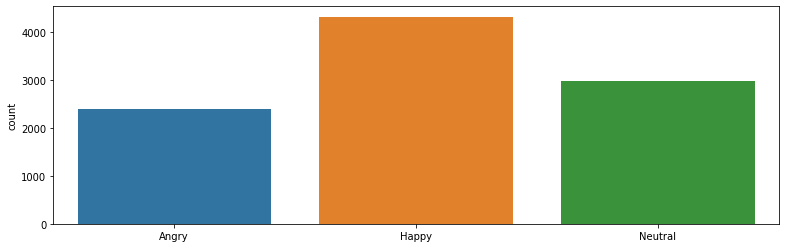


Classes [Valid]:


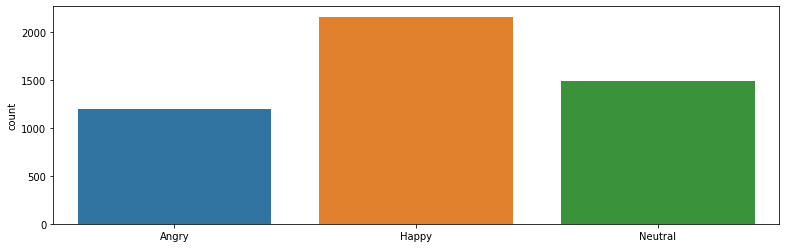


Classes [Test ]:


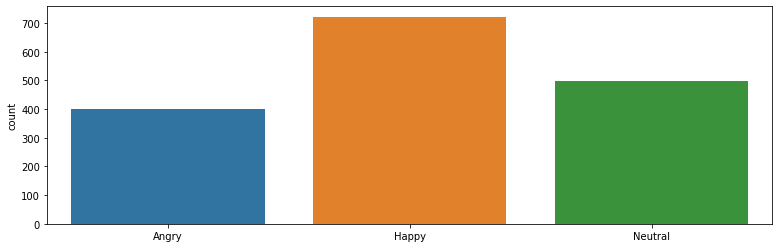

0: Train 24.70% [ 2397], Valid 24.71% [ 1199], Test 24.71% [ 1199]
1: Train 44.61% [ 4329], Valid 44.60% [ 2164], Test 44.60% [ 2164]
2: Train 30.70% [ 2979], Valid 30.69% [ 1489], Test 30.69% [ 1489]


In [ ]:
# Data Hyperparameters
Seed       = 80
batch_size = 512
TrainPerc  = 0.6
ValidPerc  = 0.3
TestPerc   = 1 - TrainPerc - ValidPerc


# Data Transformations
TransfX = transforms.Compose([
    transforms.ToTensor()
])


# Reading the Data
Classes = ["Angry", "Happy", "Neutral"]

X_DF = pd.read_csv("train_data.csv", header = None, dtype = np.uint8)
X_Data = X_DF.values.reshape(-1, 48, 48, 1)

Y_DF = pd.read_csv("train_target.csv", header = None, dtype = int)
Y_Data = Y_DF.values.squeeze()

Labels_Data  = np.array([Classes[y] for y in Y_Data])


# Creating Train/Valid/Test
TrainIndx, ValidIndx, TestIndx = train_valid_test_split(np.arange(X_Data.shape[0]), train_size = TrainPerc, valid_size = ValidPerc, Y_Data = None, random_state = Seed, shuffle = True, stratify = Y_Data)
X_Train      =      X_Data[TrainIndx]
Y_Train      =      Y_Data[TrainIndx]
Labels_Train = Labels_Data[TrainIndx]
X_Valid      =      X_Data[ValidIndx]
Y_Valid      =      Y_Data[ValidIndx]
Labels_Valid = Labels_Data[ValidIndx]
X_Test       =      X_Data[TestIndx ]
Y_Test       =      Y_Data[TestIndx ]
Labels_Test  = Labels_Data[TestIndx ]


Dataset_Train = MyImagesDataset(X_Train, Y_Train, TransfX)
Dataset_Valid = MyImagesDataset(X_Valid, Y_Valid, TransfX)
Dataset_Test  = MyImagesDataset(X_Test , Y_Test , TransfX)

Loader_Train = torch.utils.data.DataLoader(
    dataset = Dataset_Train,
    batch_size = batch_size,
    shuffle = True
)
Loader_Valid = torch.utils.data.DataLoader(
    dataset = Dataset_Valid,
    batch_size = batch_size,
    shuffle = False
)
Loader_Test = torch.utils.data.DataLoader(
    dataset = Dataset_Test,
    batch_size = batch_size,
    shuffle = False
)

# Extracting Information
tmpx, tmpy = next(iter(Loader_Valid))
K_Length, N, D_Length, H1, W1 = len(set(Y_Train.squeeze().tolist())), len(Y_Train), *tmpx.shape[1:]
print(f"X_Train.shape: {(len(Y_Train), *tmpx.shape[1:])} Y_Train.shape: {Y_Train.shape} min: {tmpx.min()} max: {tmpx.max()}")
print(f"X_Valid.shape: {(len(Y_Valid), *tmpx.shape[1:])} Y_Train.shape: {Y_Valid.shape} min: {tmpx.min()} max: {tmpx.max()}")
print(f"X_Test.shape : {(len(Y_Test ), *tmpx.shape[1:])} Y_Test.shape : {Y_Test.shape } min: {tmpx.min()} max: {tmpx.max()}")
print(f"K_Length: {K_Length}")
print(f"N: {N} H1: {H1} W1: {W1} D_Length: {D_Length}")

plt.rcParams['figure.figsize'] = [13, 4]
print(f"\nClasses [TRAIN]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Train.squeeze())])
plt.show()

print(f"\nClasses [Valid]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Valid.squeeze())])
plt.show()

print(f"\nClasses [Test ]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Test.squeeze() )])
plt.show()

CountTrain = sorted(Counter(Y_Train.squeeze()).items())
FreqTrain = np.array([kv[1] for kv in CountTrain]) / len(Y_Train) * 100
CountValid = sorted(Counter(Y_Valid.squeeze()).items())
FreqValid = np.array([kv[1] for kv in CountValid]) / len(Y_Valid) * 100
CountTest = sorted(Counter(Y_Valid.squeeze()).items())
FreqTest = np.array([kv[1] for kv in CountTest]) / len(Y_Valid) * 100
for i in range(len(FreqTrain)):
    print(f"{i}: Train {SpaceAString(f'{FreqTrain[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTrain[i][1]}', MaxLength = 5)}], Valid {SpaceAString(f'{FreqValid[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountValid[i][1]}', MaxLength = 5)}], Test {SpaceAString(f'{FreqTest[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTest[i][1]}', MaxLength = 5)}]")
plt.rcParams['figure.figsize'] = OrigFigSize

In [ ]:
conv_input_size = (H1, W1, D_Length)
input_size = np.prod(conv_input_size)
output_size = K_Length
print("conv_input_size: " + str(conv_input_size) + ", input_size: " + str(input_size) + ", D_Length: " + str(D_Length) + ", output_size: " + str(output_size))
hn1 = D_Length

ReluAlpha = 0
EluAlpha = 0

layer_type = ["conv", "stridedconv", "convpool", "dense", "dense"]
num_units = [hn1, 32, 64, 128, 256, 512]
activation = ["relu", "relu", "relu", "relu", "relu"]
dropout = [0.1, 0.1, 0.1, 0.1, 0.1]
usebias = [False, False, False, True, True] + [True]

batchnorm_momentum = [0.7, 0.7, 0.7, None, None]

conv_filter_size   = 5
conv_mode          = ["same" if l in ["conv", "stridedconv", "convpool"] else None for l in layer_type]
conv_stride        = 2
conv_dilation      = 1

conv_pool_size     = 2
conv_pool_dilation = 1 #Dilation on Pooling layer
conv_pool_stride   = conv_pool_size #Stride on Pooling: a 2x2 pooling with stride 2 will half the size of an image
conv_pool_padding  = 0 

conv_padding, conv_output_size = [2, 2, 2, None, None], [28, 28, 14, 18432, 256, 512]
print()
print("nPadding:", conv_padding)
print("X's Dims:", conv_output_size)
print("num_units", num_units)
print(f"\nbatch_size: {batch_size}")

l2_lamda = 0.10
mu = 0.99

conv_input_size: (48, 48, 1), input_size: 2304, D_Length: 1, output_size: 3

nPadding: [2, 2, 2, None, None]
X's Dims: [28, 28, 14, 18432, 256, 512]
num_units [1, 32, 64, 128, 256, 512]

batch_size: 512


In [ ]:
print(device)

model = Net(K_Length, activation, layer_type, num_units, usebias, dropout, conv_input_size, conv_output_size, conv_filter_size, conv_stride, conv_padding, batchnorm_momentum, conv_pool_size, conv_pool_stride, conv_pool_padding, conv_pool_dilation)
# if device != "cpu":
#     model = nn.DataParallel(model)
print(model)

# Initializing the Metrics
train_losses, train_metric1s, train_metric2s, train_metric3s, valid_losses, valid_metric1s, valid_metric2s, valid_metric3s = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
train_best_loss, valid_best_loss, valid_best_metric1, valid_best_metric2, valid_best_metric3 = np.Inf, np.Inf, 0, np.nan, np.nan

cuda:0
Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.1, inplace=False)
    (13): Linear(in_features=18432, out_features=256, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=256, out_features=512, bias=True

In [ ]:
# Loss Function and Optimization
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False)

In [ ]:
Epochs = int(50)
PrintInfoEverynEpochs = 1
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size = Epochs // 10 if Epochs > 10 else 3, gamma = 0.8)

new_train_losses, new_valid_losses, train_best_loss, valid_best_loss, new_train_metric1s, new_train_metric2s, new_train_metric3s, new_valid_metric1s, new_valid_metric2s, new_valid_metric3s,\
Metric1, Metric2, Metric3, valid_best_metric1, valid_best_metric2, valid_best_metric3, elapsed_time = \
    batch_gd(model, device, criterion, optimiser, scheduler, Loader_Train, Loader_Valid, epochs = Epochs, PrintInfoEverynEpochs = PrintInfoEverynEpochs,
             train_best_loss = train_best_loss, test_best_loss = valid_best_loss, BestMetric1 = valid_best_metric1, BestMetric2 = valid_best_metric2, BestMetric3 = valid_best_metric3,
             Verbose = False
    )

train_losses, valid_losses = np.append(train_losses, new_train_losses), np.append(valid_losses, new_valid_losses)
train_metric1s, train_metric2s, train_metric3s = np.append(train_metric1s, new_train_metric1s), np.append(train_metric2s, new_train_metric2s), np.append(train_metric3s, new_train_metric3s)
valid_metric1s, valid_metric2s, valid_metric3s = np.append(valid_metric1s, new_valid_metric1s), np.append(valid_metric2s, new_valid_metric2s), np.append(valid_metric3s, new_valid_metric3s)
train_loss, valid_loss, valid_metric1, valid_metric2, valid_metric3 = LastNonNan(new_train_losses), LastNonNan(new_valid_losses), Metric1, Metric2, Metric3

print(f'\ntrain_best_loss: {train_best_loss:.5f}, valid_best_loss: {valid_best_loss:.5f}, Acc: {valid_metric1:.5f}, AUC: {valid_metric2:.5f}, F1: {valid_metric3:.5f}')

Epoch 01/50, Train Loss: 1.3444, Test Loss: 1.0815 | Acc: 0.443, AUC: 0.595, F1: 0.327, Duration: 0:00:03.725608
Epoch 02/50, Train Loss: 1.0567, Test Loss: 1.0664 | Acc: 0.474, AUC: 0.625, F1: 0.408, Duration: 0:00:03.986840
Epoch 03/50, Train Loss: 1.0082, Test Loss: 1.0335 | Acc: 0.510, AUC: 0.678, F1: 0.443, Duration: 0:00:03.610828
Epoch 04/50, Train Loss: 0.9743, Test Loss: 1.0182 | Acc: 0.540, AUC: 0.707, F1: 0.491, Duration: 0:00:03.278074
Epoch 05/50, Train Loss: 0.9458, Test Loss: 1.0068 | Acc: 0.552, AUC: 0.731, F1: 0.513, Duration: 0:00:02.747564
Epoch 06/50, Train Loss: 0.9208, Test Loss: 0.9933 | Acc: 0.567, AUC: 0.749, F1: 0.558, Duration: 0:00:02.646003
Epoch 07/50, Train Loss: 0.8860, Test Loss: 0.9807 | Acc: 0.589, AUC: 0.763, F1: 0.566, Duration: 0:00:02.678984
Epoch 08/50, Train Loss: 0.8576, Test Loss: 0.9641 | Acc: 0.597, AUC: 0.780, F1: 0.583, Duration: 0:00:02.666189
Epoch 09/50, Train Loss: 0.8258, Test Loss: 0.9554 | Acc: 0.614, AUC: 0.796, F1: 0.596, Duration

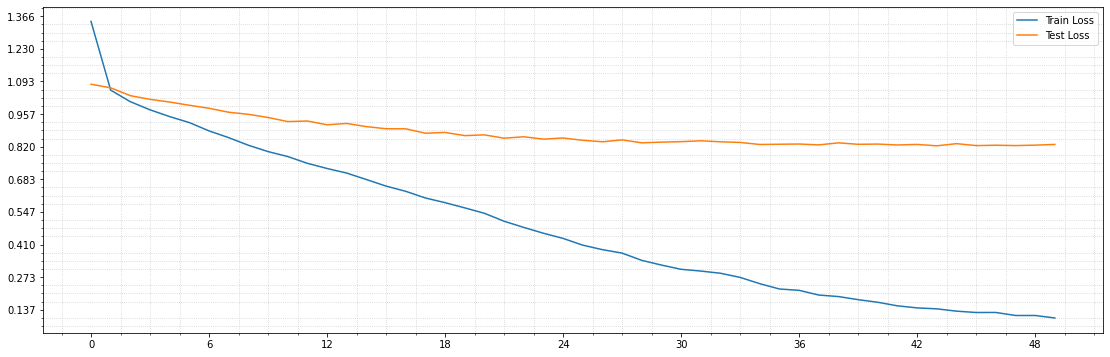

In [ ]:
PlotHistory(train_losses[-(100*2):], valid_losses[-(100*2):], figsize=(19, 6), test_alpha = 1)

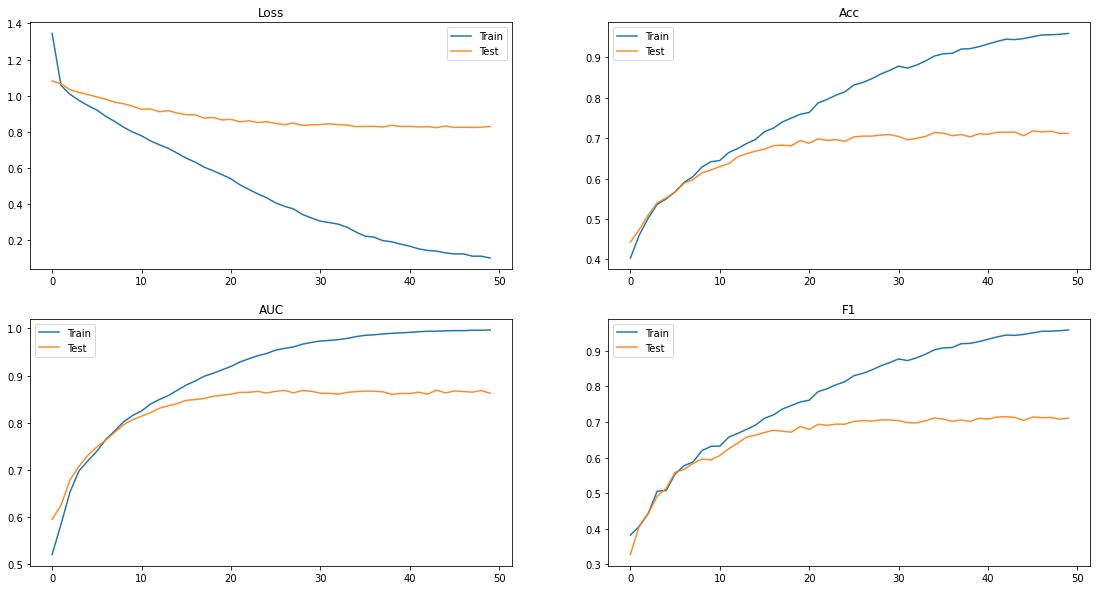

In [ ]:
PlotAllMetrics(["Loss", "Acc", "AUC", "F1"],
               [train_losses, train_metric1s, train_metric2s, train_metric3s],
               TestMetrics = [valid_losses, valid_metric1s, valid_metric2s, valid_metric3s],
               figsize = [19, 10], test_alpha = 0.90)

Sample-wise Acc: 69.90%, AUC: 0.87, F1: 0.70
Class-wise  Acc: 79.93%, Recall: 0.699, Precision: 0.696

Confusion matrix
[[232  74  93]
 [ 56 586  80]
 [ 97  87 313]]


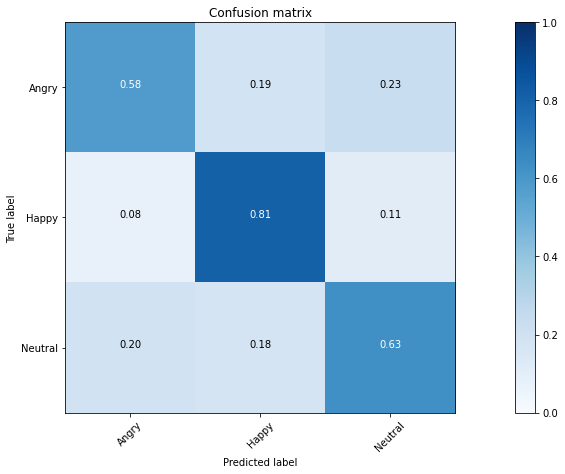


Class Angry. Sample-Wise Acc: 0.802, Recall: 0.581, Precision: 0.603, F1: 0.592


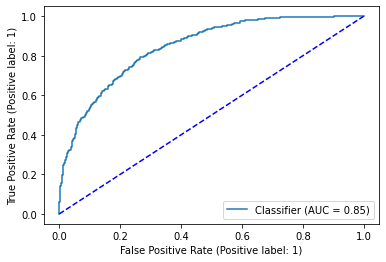


Class Happy. Sample-Wise Acc: 0.816, Recall: 0.812, Precision: 0.784, F1: 0.798


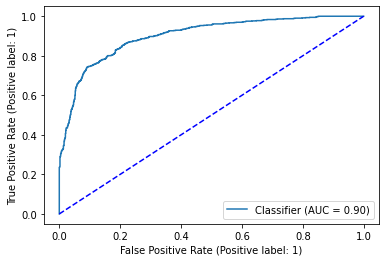


Class Neutral. Sample-Wise Acc: 0.779, Recall: 0.630, Precision: 0.644, F1: 0.637


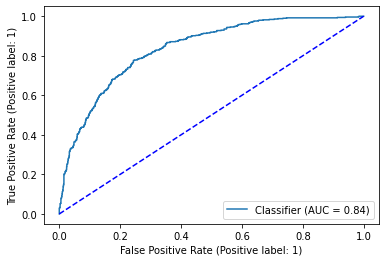

In [ ]:
Labels = Classes
with torch.no_grad(): # Making sure that we don't update the gradient outside the training part
        model.eval()
        model.to(device)
        
        # Using the Forward direction of the model to get the Predictions
        Preds_prob, Preds, Targets = EvalPredict(model, device, Loader_Test)

test_Acc, test_AUC, test_F1 = GetCategoricalMetrics(Preds_prob, Preds, Targets)
print(f'Sample-wise Acc: {test_Acc * 100:.2f}%, AUC: {test_AUC:.2f}, F1: {test_F1:.2f}')
print(f"Class-wise  Acc: {ClassAccMulti(Targets, Preds, K_Length) * 100:.2f}%, Recall: {recall_score(Targets, Preds, average = 'weighted'):.3f}, Precision: {precision_score(Targets, Preds, average = 'weighted'):.3f}\n") #'micro', 'macro', 'weighted', 'samples'

#Viewing the overall Categorical metrics and Plotting the Confusion Matrix
PlotCategoricalMetrics(Preds, Targets, Labels, normalise = True, figsize = [17, 6.5])
print("")

for k in range(K_Length):
    PredClass = Preds   == k
    TrueClass = Targets == k
    print(f"Class {Classes[k]}. Sample-Wise Acc: {np.mean(TrueClass == PredClass):.3f}, Recall: {recall_score(TrueClass, PredClass):.3f}, Precision: {precision_score(TrueClass, PredClass):.3f}, F1: {f1_score(TrueClass, PredClass):.3f}")
    RocCurveDisplay.from_predictions(TrueClass, Preds_prob[:, k])
    plt.plot(np.linspace(0, 1, num = 20), np.linspace(0, 1, num = 20), 'b--')
    plt.show()
    print()

In [ ]:
External_DF = pd.read_csv(f"test_data.csv", header = None, dtype = np.uint8)
X_External = External_DF.values.reshape(-1, 48, 48, 1)

MYDataset = MyImagesDataset(X_External, TransformationsToApply = TransfX)
MYDataLoader = torch.utils.data.DataLoader(
    MYDataset,
    batch_size = batch_size
)

model.to(device)
model.eval()
with torch.no_grad():
    TestPredictions = []
    for inputs in MYDataLoader:
        TestPredictions.append(model(inputs.to(device)))
    _, TestPredictions = torch.max(nn.Softmax(dim = 1)(torch.cat(TestPredictions)), 1)
TestResults = pd.DataFrame(TestPredictions.detach().cpu().numpy()).reset_index()
TestResults.columns = ["Id", "Category"]

FileExportPath = "Results.csv"
TestResults.to_csv(FileExportPath, sep = ',', header = True, index = False)
print(f"Results saved on: {FileExportPath}")

TestResults

Results saved on: Results.csv


,Id,Category
0,0,2
1,1,0
2,2,0
3,3,1
4,4,1
...,...,...
3960,3960,0
3961,3961,0
3962,3962,2
3963,3963,2
